# **Interview Assignments**


![](https://retainup.co/wp-content/uploads/2021/07/rfm-analysis-1024x550.png)


#  <a class="anchor" id="top"></a>

### Overview <a class="anchor" id="Overview"></a>
We'll explore the dataset and demonstrate all available features in this notebook. Then we'll extract our desired variables and answer the required first and second tasks. Afterwards, we'll model our RFM customers' clustering and label each customer based on their purchase behaviours pattern. In the end, we'll figure out customer lifetime value (CLV) for those who joined at the beginning of the year 1398.



* [Overview](#Overview)
* [EDA](#EDA)
* [Assignment 1](#Assignment1)
* [Assignment 2](#Assignment2)
* [RFM (Recency, Frequency, Monitize)](#RFM)
* [Assignment 3 - Customer Segmentation](#Segmentation)
* * [Check Skewness ](#Skewness)
* * [Scaling](#Scaling)
* * [Number of Clusters](#Clustersk)
* * [KMeans Clusters (K=5)](#KMeans)
* [Assignment 4 - CLV](#CLV)

In [1]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import jdatetime as jd
from loguru import logger 
from warnings import filterwarnings

from scipy import stats
from scipy.spatial.distance import cdist # for calculating distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [2]:
#configure the environment
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 72
plt.style.use('ggplot')
pd.options.display.float_format = '{:.0f}'.format
np.random.seed(1)
np.set_printoptions(precision=2, linewidth=100)
sns.set_context('notebook')
jd.set_locale('en')
filterwarnings('ignore')

In [3]:
revenue = pd.read_csv('data/Dataset.csv', index_col=0) # read the dataset

# EDA  <a class="anchor" id="EDA"></a>


In [4]:
def summary_statistic(df) -> pd.DataFrame:

        """
        Summary statistic of the dataset
        input: dataframe
        output: it will return a dataframe with summary statistic
        """

        feature_describe = df.describe().T.reset_index().rename(
                               columns={'index':'feature'}).drop(columns='count')

        feature_info = pd.concat([df.dtypes,
                                  df.nunique(),
                                  df.isna().sum(),
                                  df.count()], axis=1,
                    keys=['dtype', 'num_unique', 'num_Nan', 'count']).reset_index().rename(columns={'index':'feature'})

        summary_statistic_result = feature_info.merge(feature_describe, how='left', on='feature')

        return summary_statistic_result

In [5]:
summary_statistic(revenue)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,261960,7169337,4957141,465132,3267469,6663396,11227062,46549548
1,OrderID,int64,261960,0,261960,45264897,6121027,32930756,40061748,44792436,50045929,58853188
2,Date,int64,396,0,261960,20193661,4238,20190321,20190821,20191109,20200115,20200419
3,Revenue,int64,3314,0,261960,6110,5647,106,2451,5100,7960,175200


The given dataset does not have any Null value; this is great. We don't have to deal with missing values. 

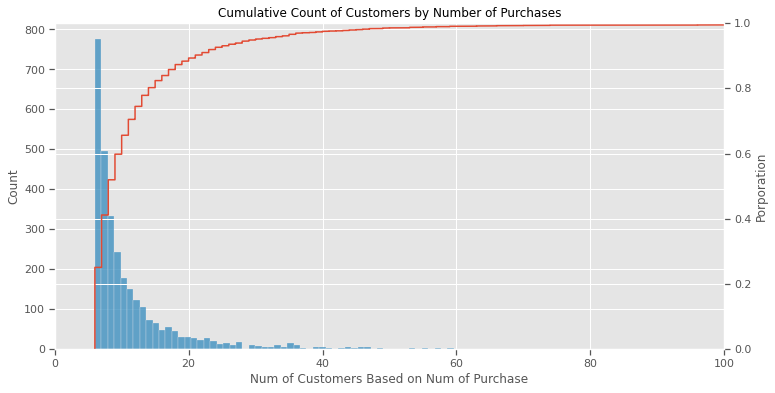

In [6]:
fig, ax1 = plt.subplots()
ax1.set_title('Cumulative Count of Customers by Number of Purchases')
ax1.set_xlabel('Num of Customers Based on Num of Purchase')
ax1.set_ylabel('Count')
sns.histplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Porporation')
sns.ecdfplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax2)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
plt.show()

Over the first look, the distribution of the count of customers based on the number of times they ordered, intrestingly follows the Pareto distribution, which almost is standard for these type of data.

In [7]:
#check if all the values in ['Date'] are numeric and follow the "%Y%m%d" format
for index, row in revenue.iterrows(): 
    assert len(str(row['Date'])) == 8

##### Parse Date <a class="anchor" id="Parse Date"></a>

Values in 'Date' are surely in need of parsing. let's parse the date to both Jalali DateTime and Gregory DateTime.


In [8]:
def convert_gregorian_persian(df, date_col, format_date):
    '''
    convert gregorian date to Jalali date
    input: dataframe, date column name, date format
    output: dataframe with Jalali date, Jalali Months, Jalali weekdays
    '''

    df['JdDate'] = [jd.date.fromgregorian(date=dt.datetime.strptime(str(i), str(format_date))) for i in df[date_col]]
    df['GDate'] = [dt.datetime.strptime(str(i), str(format_date)) for i in df[date_col]]
    df['GDate'] = [dt.datetime.date(i) for i in df['GDate']]
    df['GDate'] = df['GDate'].astype('datetime64')
    df['JdMonth'] = [jd.datetime.jmonth_short(i) for i in df['JdDate']]
    df['JdWeekday'] = [jd.datetime.jweekday_short(i) for i in df['JdDate']]
    
    return df

In [9]:
revenue = convert_gregorian_persian(revenue,'Date','%Y%m%d') #parse date to jalali

In [10]:
#last day of the Dataset
print(f'\n last Gregory Date = {revenue.GDate.max()}, \n last Jalali date = {str(revenue.JdDate.max())}')


 last Gregory Date = 2020-04-19 00:00:00, 
 last Jalali date = 1399-01-31


disturbution of Revenue (Min, Q1, Median, Q3, Max)

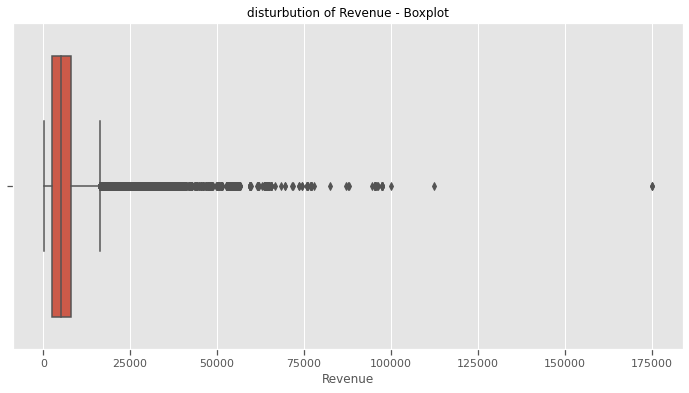

In [11]:
plt.title('disturbution of Revenue - Boxplot')
sns.boxplot(revenue.Revenue,)
plt.show()

## Assignment 1 <a class="anchor" id="Assignment1"></a>

Calculate the number of customers, number of orders, Average Order Value, Average
Frequency, total revenue in each month of 1398. (Based on Persian calendar)

In [12]:
avg_order_val = np.mean(revenue.groupby('OrderID')['Revenue'].mean()) #Average Order Value
avg_freq = np.mean(revenue.groupby('CustomerID')['OrderID'].count()) #Average Frequency

print(f'\n Average Order Value in total = {avg_order_val: .2f} \
        \n Average Frequency in total = {avg_freq: .2f}')


 Average Order Value in total =  6109.57         
 Average Frequency in total =  1.46


In [13]:
revehnue1398 = revenue[revenue['JdDate']< jd.date(1399, 1, 1)] #subset of revenue from 1398
print('AVG Revenue Per Month in 1388')
summary98 = pd.concat([revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                      .agg({'Revenue': 'mean','OrderID': 'count', 'CustomerID': 'nunique'})\
                      .rename(columns={
                                    'Revenue': 'Avg_Revenue' ,
                                    'OrderID': 'Num_Order',
                                    'CustomerID': 'Num_Customer'
                                        }),
                       revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                                            .agg({'Revenue': 'sum'})\
                                                .rename(columns={
                                                                'Revenue': 'Total_Revenue'
                                                                }).drop(columns='JdMonth')],axis=1)


summary98 #summary of 1398 each month

AVG Revenue Per Month in 1388


,JdMonth,Avg_Revenue,Num_Order,Num_Customer,Total_Revenue
0,Far,5983,3279,2789,19618499
1,Ord,6811,3503,3064,23860379
2,Kho,6354,14380,12768,91363493
3,Tir,6615,16228,14122,107350424
4,Mor,5111,28663,24708,146502637
5,Sha,5603,18630,16603,104375481
6,Meh,5642,26699,22541,150623504
7,Aba,5507,33233,28594,183010916
8,Aza,5821,30989,27344,180390183
9,Dey,6659,26642,23048,177407408


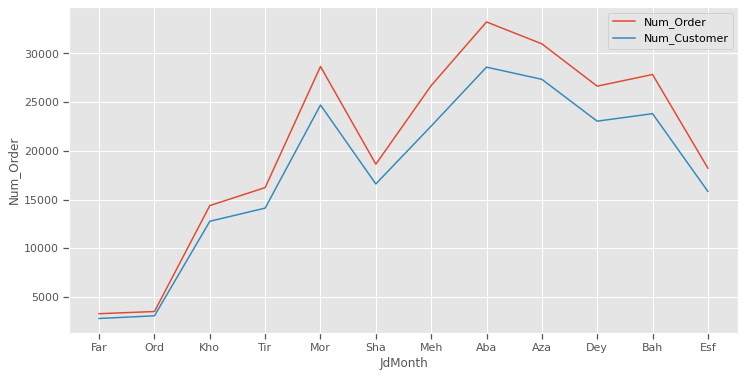

In [14]:
#plot number of orders and revenue per month in 1398
for ind, x in enumerate(summary98.columns[2:-1]): 
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
plt.legend()
plt.show()

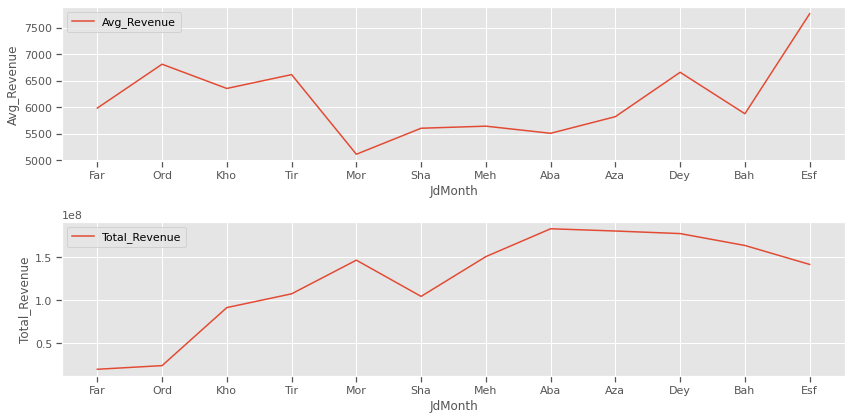

In [15]:
#plot avrage and total revenue per month in 1398
for ind, x in enumerate(summary98.columns[1::3]): 
    plt.subplot(2,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    plt.tight_layout()
plt.legend()
plt.show()

## Assignment 2 <a class="anchor" id="Assignment2"></a>
Aban 98 had the best results out of all, in total revenue, number of customers, and number of orders. <p> however Esfand 98 takes the top on avrage revenue.

In [16]:

pd.concat([summary98.JdMonth, 
           summary98[summary98==summary98.max(numeric_only=True)].drop(columns='JdMonth')],
           axis=1)



,JdMonth,Avg_Revenue,Num_Order,Num_Customer,Total_Revenue
0,Far,NaN,NaN,NaN,NaN
1,Ord,NaN,NaN,NaN,NaN
2,Kho,NaN,NaN,NaN,NaN
3,Tir,NaN,NaN,NaN,NaN
4,Mor,NaN,NaN,NaN,NaN
5,Sha,NaN,NaN,NaN,NaN
6,Meh,NaN,NaN,NaN,NaN
7,Aba,NaN,33233,28594,183010916
8,Aza,NaN,NaN,NaN,NaN
9,Dey,NaN,NaN,NaN,NaN


In [17]:
# rev_agg = revenue.groupby(pd.Grouper(key='GDate', freq='M'))[['Revenue']]
# rev_agg_dict = dict(rev_sum = rev_agg.sum(), rev_mean = rev_agg.mean(), rev_median = rev_agg.median())
# _ = 1
# for k, v in rev_agg_dict.items():
#     # print(v)
#     # break
#     plt.subplot(3,1,_)
#     plt.title(k)
#     sns.lineplot(x=v.index, y=v.Revenue)
#     _ += 1
# plt.tight_layout()
# plt.show()


In [18]:
LASTGDATE = revenue.GDate.max() #last day of the dataset in Gregorian
LASTJDATE = revenue.JdDate.max() #last day of the dataset in Jalali

## RFM (Recency, Frequency, Monitize) <a class="anchor" id="RFM"></a>

It's time to extract Recency, Frequency, Monetary(on total) for each customer.

In [19]:
#Extract recency feature (days since last purchase)
recency = revenue.groupby(['CustomerID'],as_index=False)['JdDate'].max()\
                 .rename(columns={'JdDate': 'LastPurchaseDate'})
recency['Recency'] = recency.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)


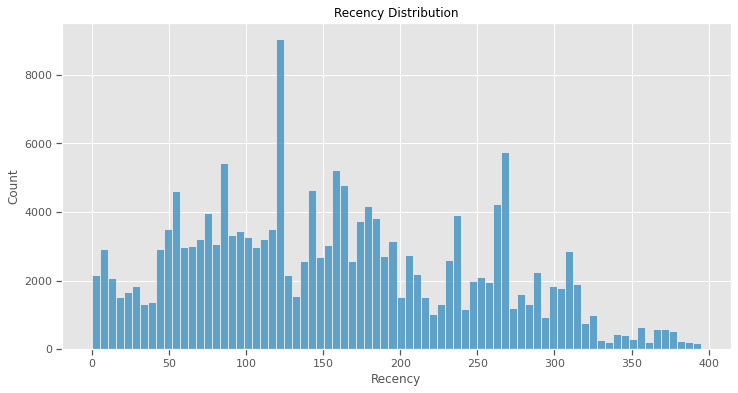

In [20]:
#plot recency distribution
plt.title('Recency Distribution')
sns.histplot(recency.Recency)
plt.show()

In [21]:
#Extract frequency feature (number of purchases per customer)
#Extract Monetary feature (total revenue per customer)
freq_mon = revenue.groupby('CustomerID', as_index=False)\
                        .agg({'OrderID': 'count',
                        'Revenue': 'sum'})\
                        .rename(columns={'OrderID' :'Frequency',
                           'Revenue':'Monetary'})

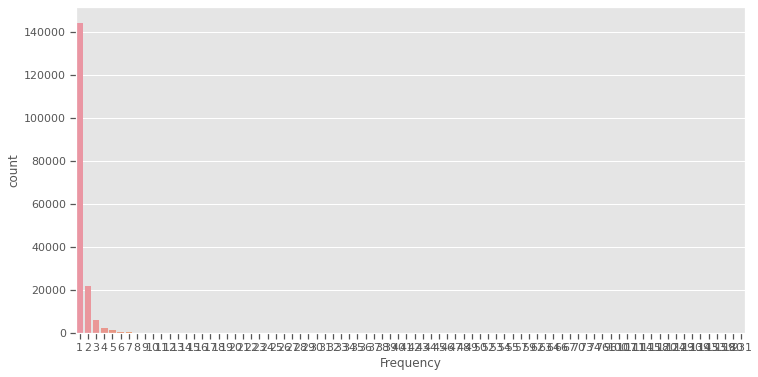

In [22]:
#plot frequency distribution
sns.countplot(freq_mon.Frequency)
plt.show()


Pareto again :)

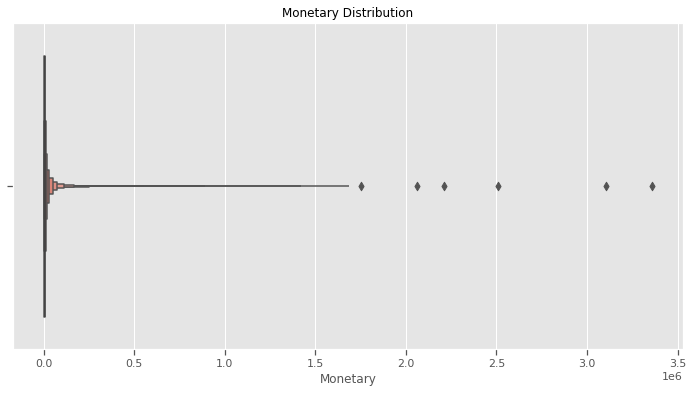

In [23]:
#plot monetary distribution - boxplot
plt.title('Monetary Distribution')
sns.boxenplot(freq_mon.Monetary)
plt.show()

In [24]:
#merge recency, frequency, monetary features
rfm_df = recency.merge(freq_mon,on='CustomerID').drop(columns='LastPurchaseDate')

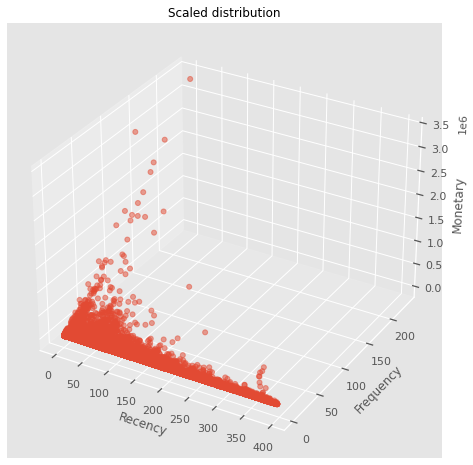

In [25]:
#plot rfm_df distribution in 3D - scatter plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_df.Recency, rfm_df.Frequency, 
    zs=rfm_df.Monetary, zdir='z', s=25, depthshade=True, alpha=0.5)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Scaled distribution')
plt.grid()
plt.show()

In [26]:
print(f'Data shape: {rfm_df.shape} \n ------------------')
summary_statistic(rfm_df)

Data shape: (179680, 4) 
 ------------------


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency,int64,82,0,179680,1,2,1,1,1,1,231
3,Monetary,int64,16962,0,179680,8907,25864,106,2899,5467,9754,3360683


## Assignment 3 - Customer Segmentation <a class="anchor" id="Segmentation"></a>

In [27]:
def check_skew(df_skew, column) -> float:
    '''
    Check skew of a column in a dataframe
    input: dataframe
    input: column name
    output: skew value
    output: disturbution plot
    '''
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title(f'Distribution of {column}')
    sns.distplot(df_skew[column], bins=50)
    return print(f"{column}'s: Skew: {skew}, : {skewtest} \n")


### Check Skewness <a class="anchor" id="Skewness"></a>

Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

Frequency's: Skew: 29.710390475484978, : SkewtestResult(statistic=605.8684556035356, pvalue=0.0) 

Monetary's: Skew: 50.91426917719234, : SkewtestResult(statistic=681.9671668363789, pvalue=0.0) 



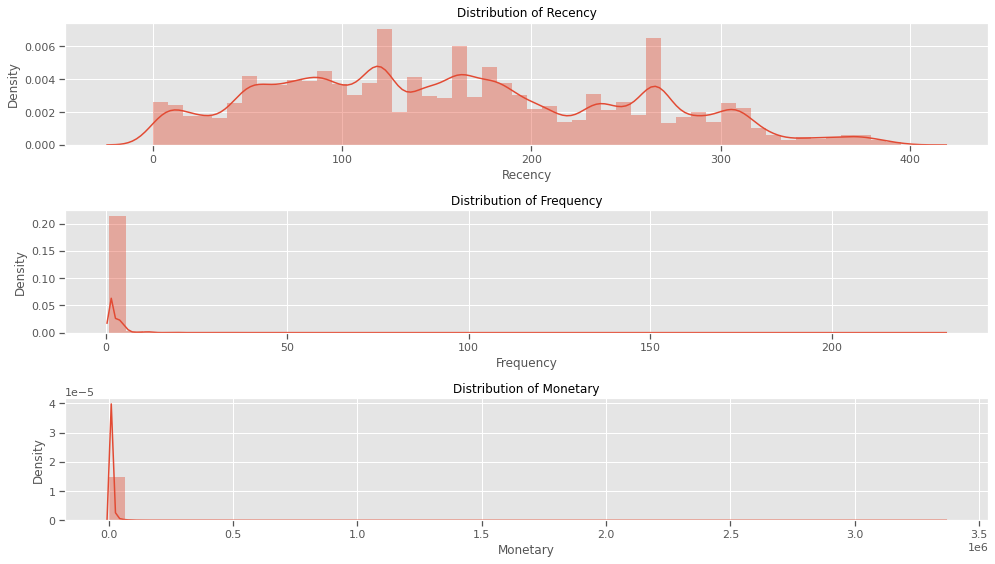

In [28]:
#check skew of each feature
plt.figure(figsize=(14,8))
for ind, i in enumerate(rfm_df.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_df, i)
plt.tight_layout()
plt.show()

### Scaling <a class="anchor" id="Scaling"></a>

We have to deal with this heavy skewness, and data have extreme outliers. I believe logarithmic scaling for Frequency and Monetary may work; we'll use more sophisticated transformers if it doesn't; then, we'll use standard scaling to scale our data so that our model can make a sense out of it.

In [29]:
rfm_log = pd.concat([rfm_df[['CustomerID', 'Recency']], np.log(rfm_df[['Frequency', 'Monetary']])], axis=1)


In [30]:
summary_statistic(rfm_log)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency,float64,82,0,179680,0,0,0,0,0,0,5
3,Monetary,float64,16962,0,179680,9,1,5,8,9,9,15


Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

Frequency's: Skew: 2.955378295305225, : SkewtestResult(statistic=282.33859954303, pvalue=0.0) 

Monetary's: Skew: -0.3747150407190465, : SkewtestResult(statistic=-62.763502952820964, pvalue=0.0) 



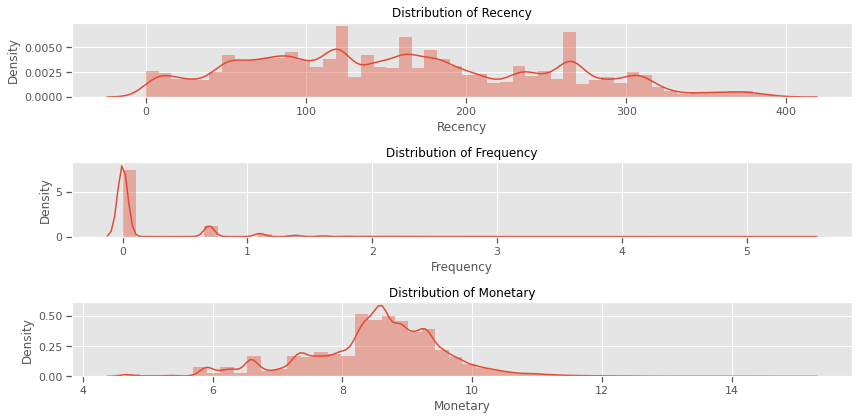

In [31]:
for ind, i in enumerate(rfm_log.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_log, i)
plt.tight_layout()
plt.show()

still too much skewness, let's use Power Trasnformer (to make data more Gaussian-like)
- more on this transformer on [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer)

In [32]:
pt = PowerTransformer(method='yeo-johnson', standardize=True,) 
skl_yeojohnson = pt.fit(rfm_df)
#get the Lambdas
print(f' Lambdas :{skl_yeojohnson.lambdas_}')
calc_lambdas = skl_yeojohnson.lambdas_
#Transform the data 
skl_yeojohnson = pt.transform(rfm_df)
#Pass the transformed data into a new dataframe 
rfm_xt = pd.DataFrame(data=skl_yeojohnson, columns=rfm_df.columns)

 Lambdas :[ 0.53  0.64 -7.14  0.08]


Recency's: Skew: -0.14400889811927017, : SkewtestResult(statistic=-24.794511907258524, pvalue=1.0274124318961074e-135) 

Frequency's: Skew: 1.5267390918593293, : SkewtestResult(statistic=195.54814262866296, pvalue=0.0) 

Monetary's: Skew: 0.03653997137818537, : SkewtestResult(statistic=6.321435819915521, pvalue=2.5914400701924073e-10) 



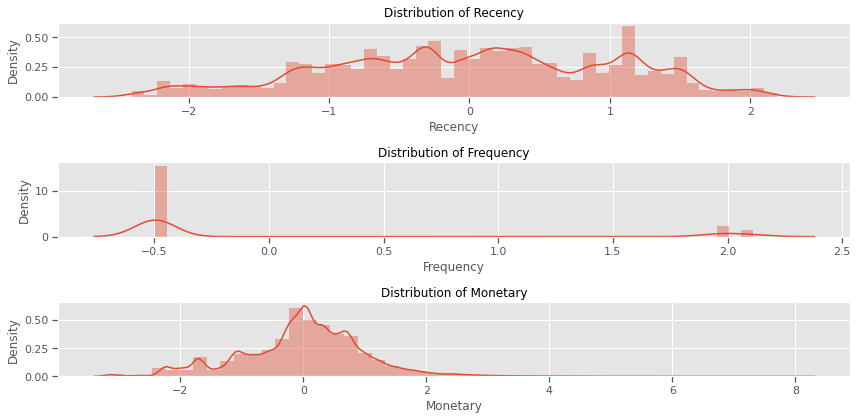

In [33]:
# plot the transformed data distribution
for ind, i in enumerate(rfm_xt.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_xt, i)
plt.tight_layout()
plt.show()

much better

In [34]:
scaler = StandardScaler() #StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_xt)[:,1:] #Scale the data

2022-04-11 16:09:08.988 | INFO     | __main__:<cell line: 2>:10 - 
 0's: Skew: -0.1440088981192702, : SkewtestResult(statistic=-24.794511907258546, pvalue=1.0274124318954637e-135) 

2022-04-11 16:09:09.750 | INFO     | __main__:<cell line: 2>:10 - 
 1's: Skew: 1.5267390918593293, : SkewtestResult(statistic=195.54814262866296, pvalue=0.0) 

2022-04-11 16:09:10.543 | INFO     | __main__:<cell line: 2>:10 - 
 2's: Skew: 0.03653997137818537, : SkewtestResult(statistic=6.321435819915521, pvalue=2.5914400701924073e-10) 



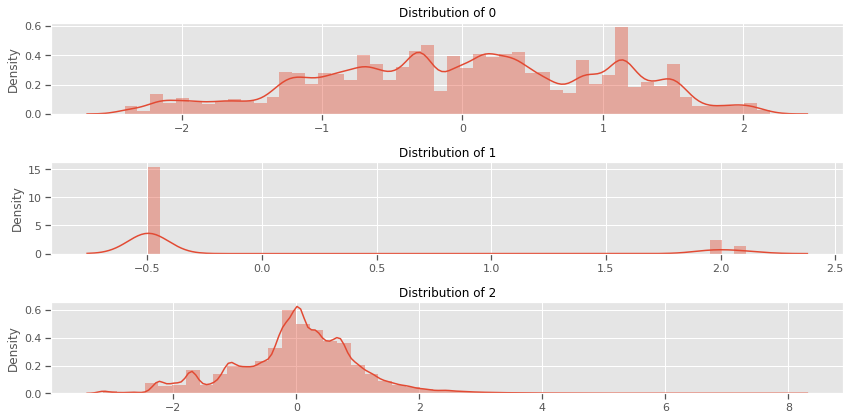

In [35]:
#plot the scaled data distribution
for i in range(3):
    plt.subplot(3,1, i+1)
    # check_skew(rfm_log, i)
    # check_skew(scaler.fit_transform(rfm_df),)
    skew = stats.skew(scaled_rfm[:,i])
    skewtest = stats.skewtest(scaled_rfm[:,i])
    plt.title(f'Distribution of {i}')
    sns.distplot(scaled_rfm[:,i])
    logger.info(f"\n {i}'s: Skew: {skew}, : {skewtest} \n")
plt.tight_layout()
plt.show()



In [36]:
rfm_scaled = pd.DataFrame(scaled_rfm, columns=rfm_log.columns[1:])

print(f'Data shape: {rfm_scaled.shape} \n ------------------')
summary_statistic(rfm_scaled)

Data shape: (179680, 3) 
 ------------------


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,Recency,float64,396,0,179680,0,1,-2,-1,0,1,2
1,Frequency,float64,77,0,179680,-0,1,-0,-0,-0,-0,2
2,Monetary,float64,16962,0,179680,-0,1,-3,-1,0,1,8


### Number of Clusters <a class="anchor" id="Clustersk"></a>

Before labelling our customers, we have to determine the optimal number of clusters. For Kmeans clustering, this is applicable through Elbow Method using distortion (the sum of the squared distances between each observation vector and its dominating centroid), inertia (a measure of how internally coherent clusters are) extracted from `K` number of clusters, 3D disturbution, and snakeplots of values metrics (R,F,M) as it's usual for RFM analysis.

In [37]:
K = range(1,10) 
def get_distortions(df): 
    '''
    Calculate the distortions for each feature in the dataset
    input: scaled data
    output: distortions - list of distortions for each feature
    output: inertia - inertia of the resulting clusters
    '''
    distortions = [] 
    inertias = [] 
    for k in K: 
        kmeanModel = KMeans(n_clusters=k).fit(df) 
        kmeanModel.fit(df) 
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 
                                 'euclidean'), axis=1)) / df.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
    return distortions, inertias
distortions, inertias = get_distortions(rfm_scaled)

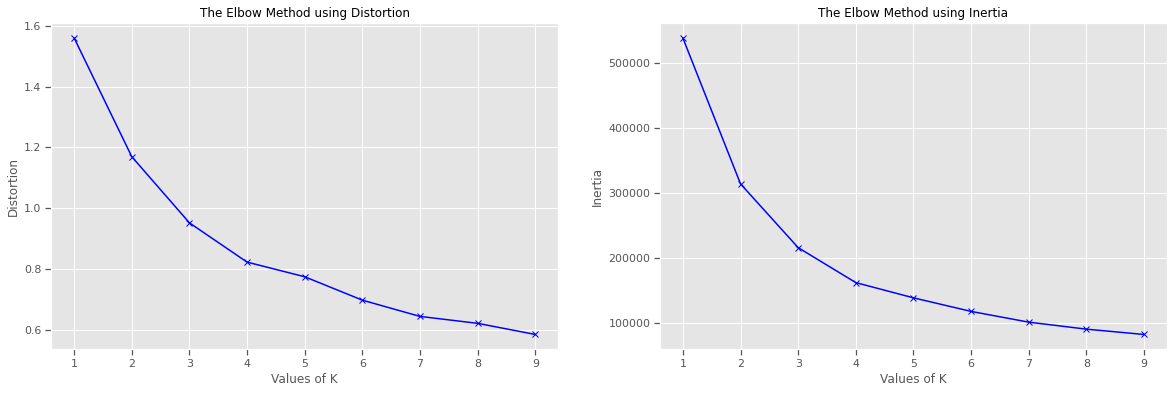

In [38]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(K, distortions, 'bx-') #plot the distortions
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

plt.subplot(1,2,2)
plt.plot(K, inertias, 'bx-') #plot the inertias
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia')
plt.show() 

In [73]:
#kmeans clustering for the scaled data
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm) -> pd.DataFrame:
    ''''
    input: scaled data
    input: clusters number
    input: original data
    output: dataframe with cluster labels
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 42)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_new.Recency, df_new.Frequency, zs=df_new.Monetary, 
                c=df_new.Cluster, zdir='z', s=25, depthshade=True, alpha=0.5)
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.set_title(f'{clusters_number} cluster distribution')
    plt.tight_layout()
    plt.grid()
    plt.show()
    return df_new

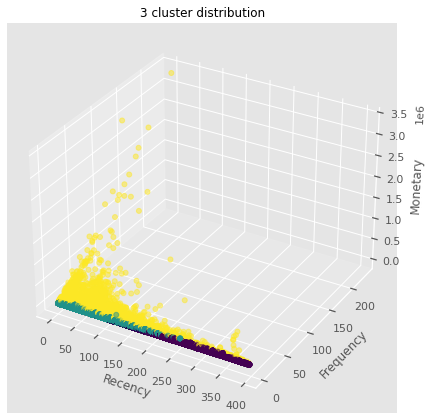

In [74]:
#kmeans clustering K=3 for the scaled data
df_rfm_k3 = kmeans(rfm_scaled, 3, rfm_df)

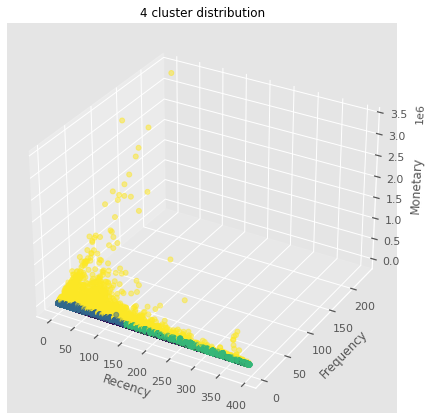

In [75]:
#kmeans clustering K=4 for the scaled data
df_rfm_k4 = kmeans(rfm_scaled, 4, rfm_df)

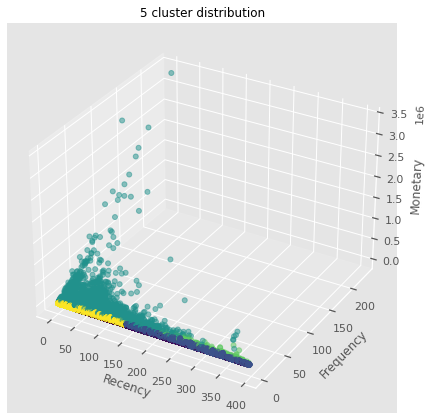

In [76]:
#kmeans clustering K=5 for the scaled data
df_rfm_k5 = kmeans(rfm_scaled, 5, rfm_df)

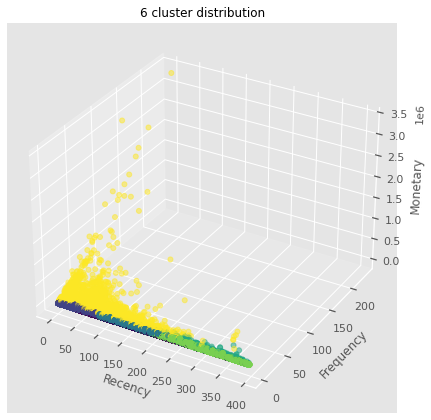

In [77]:
#kmeans clustering K=6 for the scaled data
df_rfm_k6 = kmeans(rfm_scaled, 6, rfm_df)

In [78]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    '''
    input: scaled data
    input: dataframe with cluster labels
    input: original data
    output: plot of the clusters
    '''
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    g = sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    return g
    

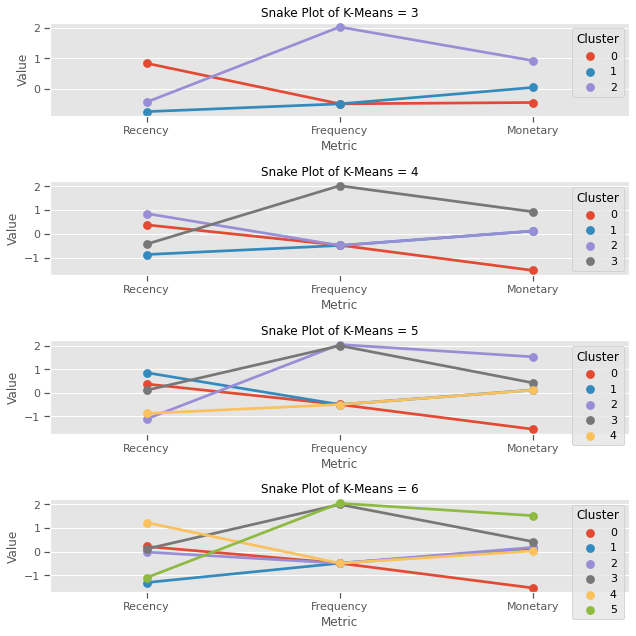

In [79]:
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 3') #plot 
snake_plot(rfm_scaled, df_rfm_k3, rfm_df)

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_scaled, df_rfm_k4, rfm_df)

plt.subplot(4, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_scaled, df_rfm_k5, rfm_df)

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 6')
snake_plot(rfm_scaled, df_rfm_k6, rfm_df)

plt.tight_layout()
plt.show()

### KMeans Clusters (K=5) <a class="anchor" id="KMeans"></a>
From the 3d distubuation graphs and the snake plots, it is evident that having a cluster value of 5, segments our customers well. We could also go for a higher number of clusters, it completely depends on the project and company's measurements.

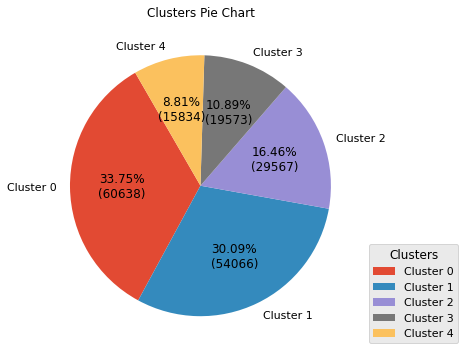

In [80]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f'{pct :.2f}%\n({absolute :d})'

ax.set_title('Clusters Pie Chart')
labels = ['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3','Cluster 4']
ax.pie(df_rfm_k5.Cluster.value_counts(),
        labels = labels,
        autopct=lambda pct: func(pct, df_rfm_k5.Cluster.value_counts()),
        textprops=dict(color='k'), startangle=120
        )
ax.legend(title='Clusters',
          loc='lower left',
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [81]:
cluster_results = pd.concat([
                        df_rfm_k5.groupby('Cluster').mean().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster').median().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster').max().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster').min().drop(columns='CustomerID')
                        ], 
                        keys=['mean', 'median', 'max', 'min'],
                        axis=1)
cluster_results

mean                     median                        max  \
        Recency Frequency Monetary Recency Frequency Monetary Recency   
Cluster                                                                 
0           188         1     1072     175         1      900     392   
1           236         1     6796     235         1     5800     395   
2            64         5    36273      59         3    20636     358   
3           163         2    10095     158         2     8610     392   
4            80         1     7115      85         1     5321     146   

                               min                     
        Frequency Monetary Recency Frequency Monetary  
Cluster                                                
0               2     2899      39         1      106  
1               1    97560     146         1     1560  
2             231  3360683       0         1     1685  
3              15   133049       2         2      422  
4               1    65504       0         1      660

##### Cluster 0:
- 

##### Cluster 1:

##### Cluster 2:
- our most royal customers, they have the 

##### Cluster 3:

##### Cluster 4:



In [72]:
result_ = df_rfm_k5.groupby('Cluster', as_index=False)
result_[['Recency']].describe().drop(columns=[('Recency', 'count'), ('Recency', 'std')])[('Recency', 'mean')]

0    80
1   187
2    64
3   236
4   163
Name: (Recency, mean), dtype: float64

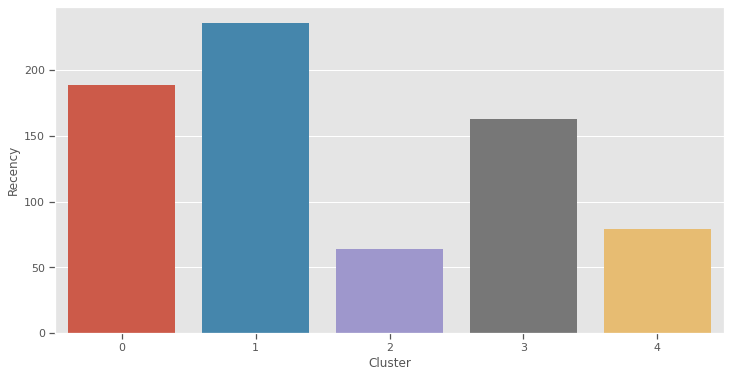

In [51]:
sns.barplot(x='Cluster', y='Recency', data=result_.mean())
plt.show()
# sns.barplot(x='Cluster', y='Recency', data=data.median())
# sns.barplot(x='Cluster', y='Recency', data=data.max())
# sns.barplot(x='Cluster', y='Recency', data=data.min())

## Assignment 4 - CLV <a class="anchor" id="CLV"></a>
Calculate CLV for customers who have been joined in Farvardin. (Assume that each
customer's join date is the same as the date of their first order) (Bonus Question)

| Parameter | Definition |
| --- | --- |
| CLV | ARPU (Average Revenue per User)/ChurnRate |
|ARPU | Average Revenue per User |
| Churn customer | A customer who did not purchase in the last 365 days |


In [53]:
# customer's join date is the same as the date of their first order
customer_groupby = revenue.groupby(['CustomerID'], as_index=False)
customer_join_date = customer_groupby[['JdDate']].min()

In [54]:
far_joined_customers = customer_join_date[(customer_join_date.JdDate < jd.date(1398, 2, 1))\
                    | (customer_join_date.JdDate >= jd.date(1399, 1, 1))].sort_values(by='JdDate').reset_index()

In [55]:
recency_ = customer_groupby['JdDate'].max().rename(columns={'JdDate': 'LastPurchaseDate'})
recency_['Recency'] = recency_.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)
recency_['ChurnCustomer']= recency_.Recency.apply(lambda x:1 if x > 365 else 0)
recency_.drop(columns=['LastPurchaseDate'], inplace=True)

arpu_far = far_joined_customers.merge(customer_groupby.Revenue.mean(), on='CustomerID', how='left')
arpu_far.rename(columns={'Revenue':'AvgRevenue', 'JdDate':'JoinedDate'}, inplace=True)
arpu_far.drop(columns=['index'], inplace=True)

arpu_far_churn = arpu_far.merge(recency_, on='CustomerID', how='left')

In [56]:
CHURN_RATE = recency_.ChurnCustomer.sum()/ recency_.shape[0] * 100

In [57]:
arpu_far_churn['CLV'] = arpu_far_churn.AvgRevenue / CHURN_RATE

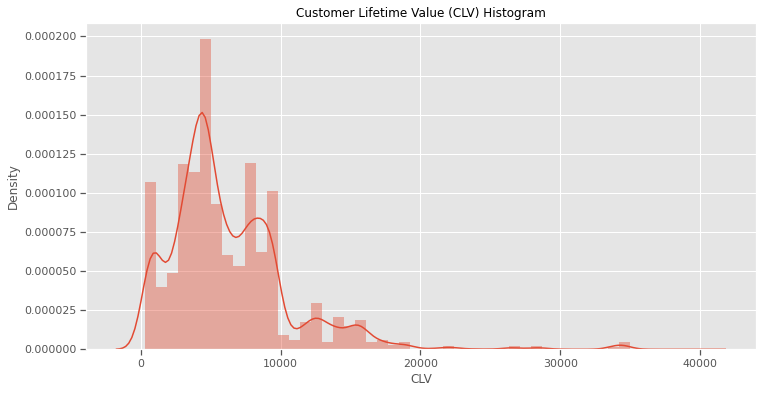

In [62]:
plt.title('Customer Lifetime Value (CLV) Histogram')
sns.distplot(arpu_far_churn['CLV'])
plt.show()

[&uarr; back to top](#top) 